# Pathfinding using various algotithms

This notebook demonstrates the use of various pathfinding algorithms on a road network graph generated from OpenStreetMap data.

## Setup and Graph Preparation

First, we import necessary libraries and load the graph data from OSMnx. We set a default speed and clean up the 'maxspeed' attribute for each edge in the graph. Additionally, we define the 'weight' of each edge to represent travel time (assuming constant speed).

In [143]:
import heapq
import random
import osmnx as ox

place_name = "San Francisco, California, USA"
G = ox.graph_from_place(place_name, network_type='drive')

# Cleaning 'maxspeed' attribute and setting edge weights
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40  # Default speed
    if "maxspeed" in G.edges[edge]:
        maxspeed_value = G.edges[edge]["maxspeed"]
        if isinstance(maxspeed_value, list):
            speeds = [int(speed) for speed in maxspeed_value if speed.isdigit()]
            maxspeed = min(speeds) if speeds else maxspeed  # Use default if no valid speeds found
        elif isinstance(maxspeed_value, str):
            maxspeed = int(maxspeed_value) if maxspeed_value.isdigit() else maxspeed  # Use default if not a digit
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

## Edge and Node Styling Functions

These functions are used to style the nodes and edges of the graph based on their state (visited, unvisited, active, part of the final path).

In [144]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#2432B0"
    G.edges[edge]["alpha"] = 0.3
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#2432B0"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#3F50E7'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

## Graph Plotting Function

This function is used to visualize the graph with the applied styles

In [145]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#0F1126",
        dpi=300
    )

## Pathfinding Algorithms

We implement several pathfinding algorithms to find routes from a random start node to a random end node within the graph.

### Dijkstra's Algorithm

This section covers the implementation and execution of Dijkstra's algorithm.

In [146]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iterations:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

### A* Algorithm

Here, we implement the A* algorithm, which uses a heuristic to improve on the efficiency of Dijkstra's algorithm.

In [147]:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iterations:", step)
                plot_graph()
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

### Breadth-First Search (BFS)

This section demonstrates a simple BFS algorithm on the graph.

In [148]:
def bfs(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    queue = [orig]
    step = 0
    while queue:
        node = queue.pop(0)
        if node == dest:
            if plot:
                print("Iterations:", step)
                plot_graph()
            return
        if not G.nodes[node]["visited"]:
            G.nodes[node]["visited"] = True
            for edge in G.out_edges(node):
                style_visited_edge((edge[0], edge[1], 0))
                neighbor = edge[1]
                if not G.nodes[neighbor]["visited"]:
                    G.nodes[neighbor]["previous"] = node
                    queue.append(neighbor)
                    for edge2 in G.out_edges(neighbor):
                        style_active_edge((edge2[0], edge2[1], 0))
            step += 1


## Path Reconstruction

After finding a path using one of the algorithms, this function reconstructs and visualizes the path from the start node to the destination.

In [149]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        if curr in G.nodes:
            prev = G.nodes[curr].get("previous")
            if prev is not None and (prev, curr, 0) in G.edges:  # Check if the edge exists
                dist += G.edges[(prev, curr, 0)]["length"]
                speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
                style_path_edge((prev, curr, 0))
            curr = prev  # Update current node to previous one
        else:
            break  # Exit the loop if 'curr' is not in G.nodes
    dist /= 1000
    if plot:
        print(f"Distance: {dist} km")
        print(f"Avg. speed: {sum(speeds)/len(speeds)} km/h")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60} minutes")
        plot_graph()

## Execution and Visualization

In this section, we execute each pathfinding algorithm on the graph and visualize the resulting paths. For each algorithm, we will:

1. Select random start and end nodes.
2. Execute the algorithm.
3. Reconstruct and visualize the resulting path.

In [161]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

### Dijkstra's Algorithm Execution

Here, we use Dijkstra's algorithm to find the shortest path from a randomly selected start node to a randomly selected end node.

Iterations: 5417


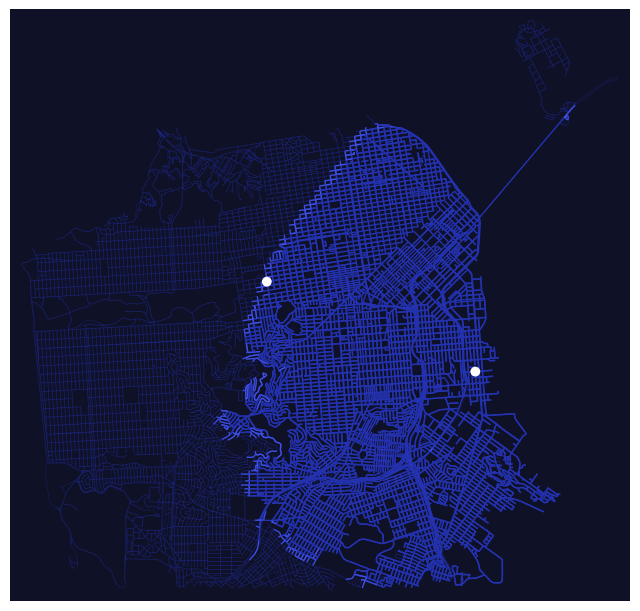

Distance: 6.956051000000001 km
Avg. speed: 40.0 km/h
Total time: 10.434076500000002 minutes


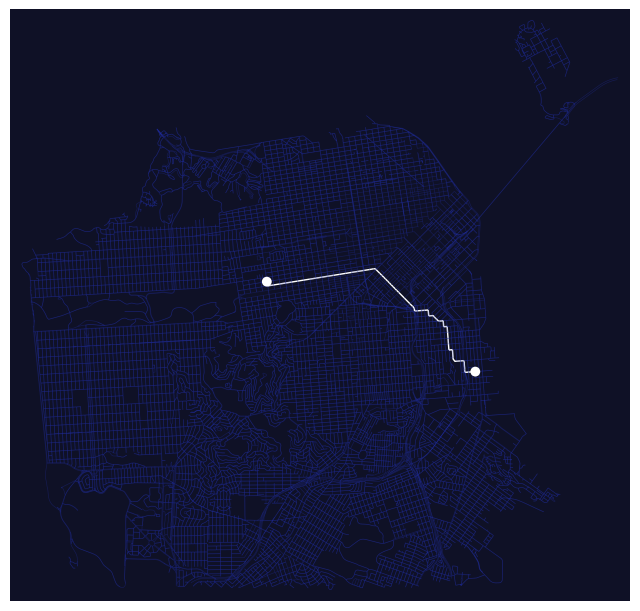

In [163]:
dijkstra(start, end, plot=True)
reconstruct_path(start, end, plot=True)

### A* Algorithm Execution

In this section, we apply the A* algorithm, utilizing heuristics to find the most efficient path between two points.

Iterations: 1536


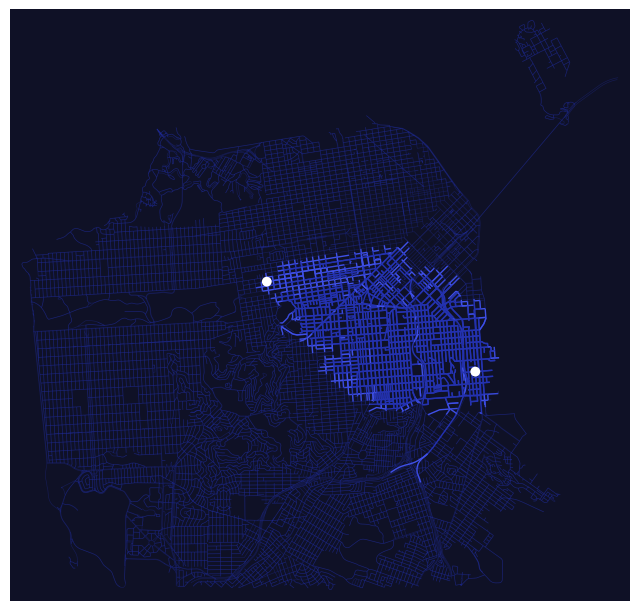

Distance: 6.974527000000002 km
Avg. speed: 40.0 km/h
Total time: 10.461790500000003 minutes


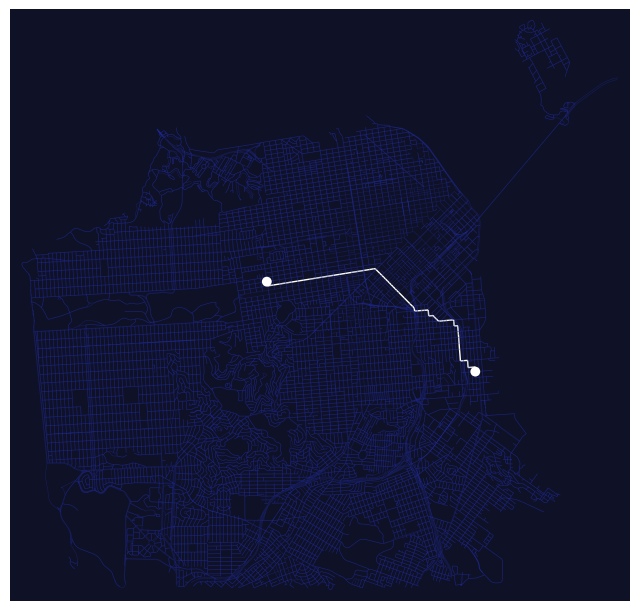

In [164]:
a_star(start, end, plot=True)
reconstruct_path(start, end, plot=True)

### Breadth-First Search (BFS) Execution

Below, we demonstrate the application of the Breadth-First Search algorithm to navigate from the start to the end node.

Iterations: 6780


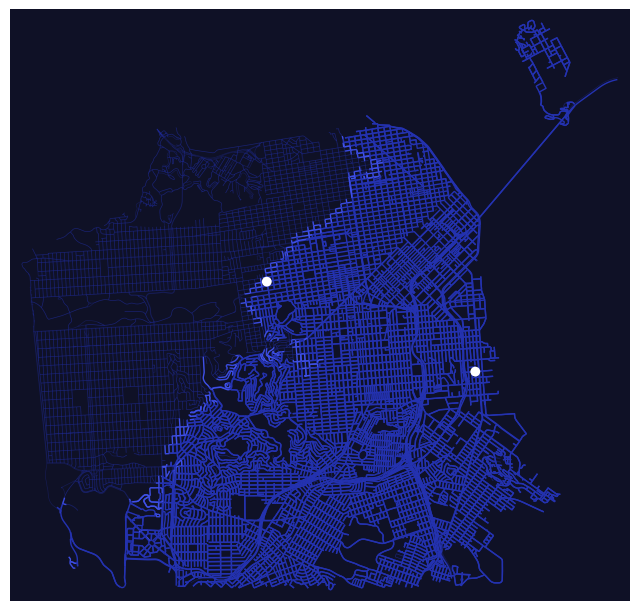

Distance: 8.375878 km
Avg. speed: 40.0 km/h
Total time: 12.563817 minutes


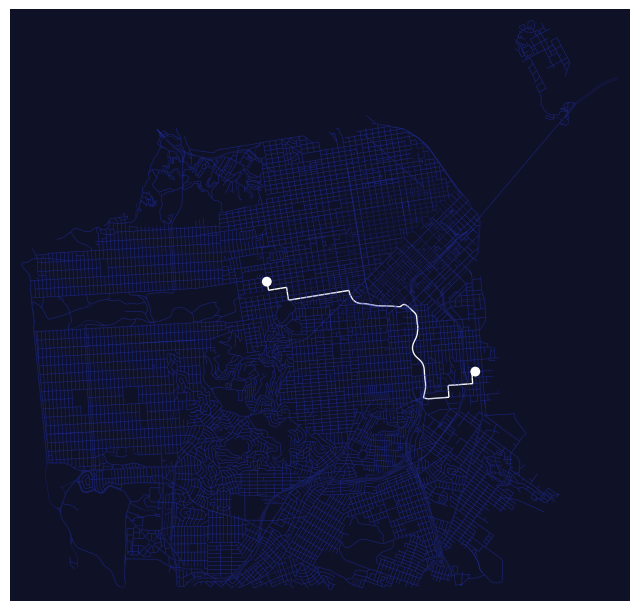

In [165]:
bfs(start, end, plot=True)
reconstruct_path(start, end, plot=True)